In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('/content/activity_tracker_dataset.csv')
df_vibe = pd.read_csv('/content/unique_employees_weighted_vibe.csv')

In [ ]:
df.shape

(500, 6)

In [ ]:
df_vibe.shape

(315, 2)

In [ ]:
df.head()

,Employee_ID,Date,Teams_Messages_Sent,Emails_Sent,Meetings_Attended,Work_Hours
0,EMP0048,1/1/2023,33,8,9,6.69
1,EMP0207,1/2/2023,21,29,2,5.42
2,EMP0112,1/3/2023,21,1,3,9.21
3,EMP0309,1/4/2023,14,13,6,7.78
4,EMP0142,1/5/2023,18,3,0,5.80


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

In [ ]:
df.head()

,Employee_ID,Date,Teams_Messages_Sent,Emails_Sent,Meetings_Attended,Work_Hours
0,EMP0048,2023-01-01,33,8,9,6.69
1,EMP0207,2023-01-02,21,29,2,5.42
2,EMP0112,2023-01-03,21,1,3,9.21
3,EMP0309,2023-01-04,14,13,6,7.78
4,EMP0142,2023-01-05,18,3,0,5.80


In [ ]:
df.sort_values(by=["Employee_ID", "Date"], ascending=[True, False], inplace=True)
df.head()

,Employee_ID,Date,Teams_Messages_Sent,Emails_Sent,Meetings_Attended,Work_Hours
492,EMP0002,2024-05-07,38,8,9,5.45
392,EMP0002,2024-01-28,37,7,6,7.05
340,EMP0003,2023-12-07,16,28,2,4.09
241,EMP0005,2023-08-30,16,28,7,4.80
226,EMP0005,2023-08-15,11,4,5,9.95


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
decay_factor = 1 / 5
df["days_since"] = df.groupby("Employee_ID")["Date"].transform(lambda x: (x.max() - x).dt.days)
df["weight"] = np.exp(-decay_factor * df["days_since"])
df.head()

,Employee_ID,Date,Teams_Messages_Sent,Emails_Sent,Meetings_Attended,Work_Hours,days_since,weight
492,EMP0002,2024-05-07,38,8,9,5.45,0,1.000000e+00
392,EMP0002,2024-01-28,37,7,6,7.05,100,2.061154e-09
340,EMP0003,2023-12-07,16,28,2,4.09,0,1.000000e+00
241,EMP0005,2023-08-30,16,28,7,4.80,0,1.000000e+00
226,EMP0005,2023-08-15,11,4,5,9.95,15,4.978707e-02


In [ ]:
weighted_activity = df.groupby("Employee_ID").apply(
    lambda emp: pd.Series({
        "weighted_teams_msgs_sent": np.sum(emp["Teams_Messages_Sent"] * emp["weight"]) / np.sum(emp["weight"]),
        "weighted_emails_sent": np.sum(emp["Emails_Sent"] * emp["weight"]) / np.sum(emp["weight"]),
        "weighted_meetings_attended": np.sum(emp["Meetings_Attended"] * emp["weight"]) / np.sum(emp["weight"]),
        "weighted_work_hours": np.sum(emp["Work_Hours"] * emp["weight"]) / np.sum(emp["weight"]),
    })
).reset_index()

weighted_activity.head()

<ipython-input-11-4bf08a7c7d75>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_activity = df.groupby("Employee_ID").apply(


,Employee_ID,weighted_teams_msgs_sent,weighted_emails_sent,weighted_meetings_attended,weighted_work_hours
0,EMP0002,3.800000e+01,8.000000,9.000000,5.450000
1,EMP0003,1.600000e+01,28.000000,2.000000,4.090000
2,EMP0005,1.576287e+01,26.861779,6.905148,5.044243
3,EMP0006,4.900000e+01,17.000000,6.000000,6.890000
4,EMP0009,6.770843e-11,26.000000,2.000000,7.220000


In [ ]:
weighted_activity.shape

(312, 5)

In [ ]:
df_merged = pd.merge(weighted_activity, df_vibe[['Employee_ID', 'Weighted_vibe_Score']], on='Employee_ID', how='right')
df_merged.head()

,Employee_ID,weighted_teams_msgs_sent,weighted_emails_sent,weighted_meetings_attended,weighted_work_hours,Weighted_vibe_Score
0,EMP0002,38.000000,8.000000,9.000000,5.450000,1.0000
1,EMP0003,16.000000,28.000000,2.000000,4.090000,2.9996
2,EMP0004,NaN,NaN,NaN,NaN,4.0000
3,EMP0005,15.762871,26.861779,6.905148,5.044243,3.0000
4,EMP0006,49.000000,17.000000,6.000000,6.890000,5.0000


In [ ]:
df_merged.shape

(315, 6)

In [ ]:
df_merged.isna().sum()

,0
Employee_ID,0
weighted_teams_msgs_sent,116
weighted_emails_sent,116
weighted_meetings_attended,116
weighted_work_hours,116
Weighted_vibe_Score,0


In [ ]:
df_merged['weighted_work_hours'].fillna(df_merged['weighted_work_hours'].min(), inplace=True)

<ipython-input-16-1380e22de362>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['weighted_work_hours'].fillna(df_merged['weighted_work_hours'].min(), inplace=True)


In [ ]:
df_merged.fillna(0, inplace=True)

In [ ]:
df_merged.isna().sum()

,0
Employee_ID,0
weighted_teams_msgs_sent,0
weighted_emails_sent,0
weighted_meetings_attended,0
weighted_work_hours,0
Weighted_vibe_Score,0


In [ ]:
independent_features = ['weighted_teams_msgs_sent', 'weighted_emails_sent',
                        'weighted_meetings_attended', 'weighted_work_hours']

correlation_matrix = df_merged[independent_features].corr()

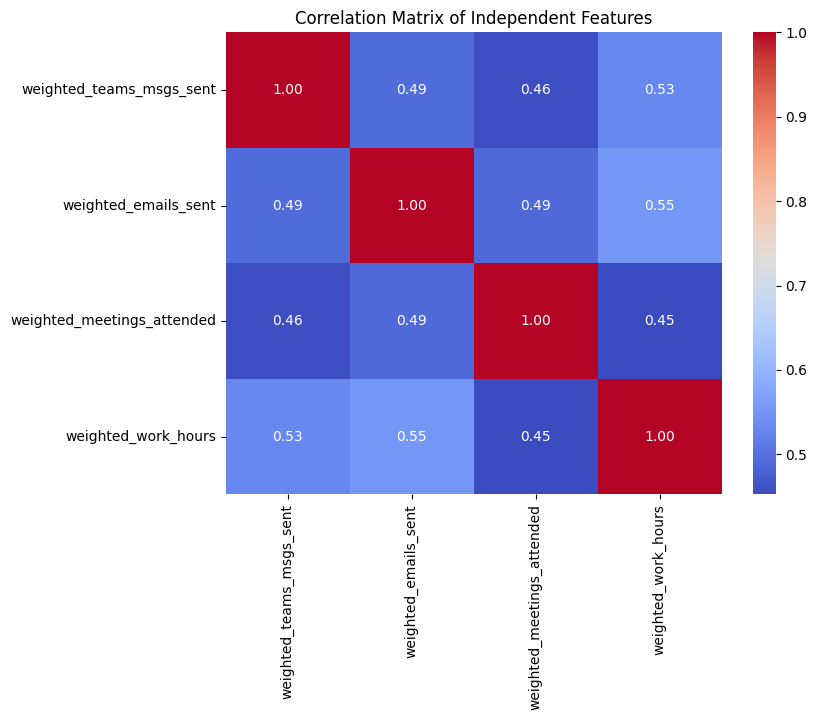

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Independent Features")
plt.show()

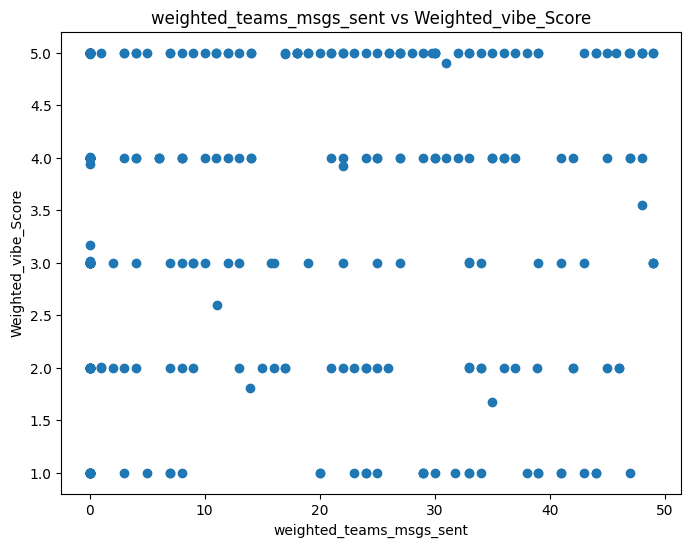

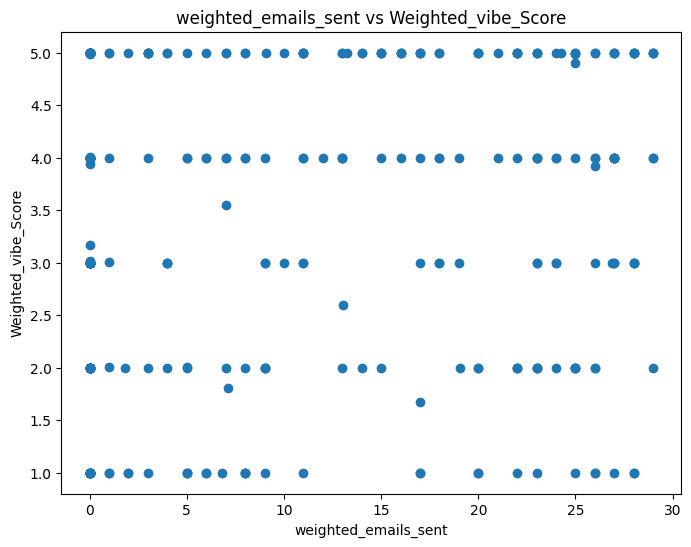

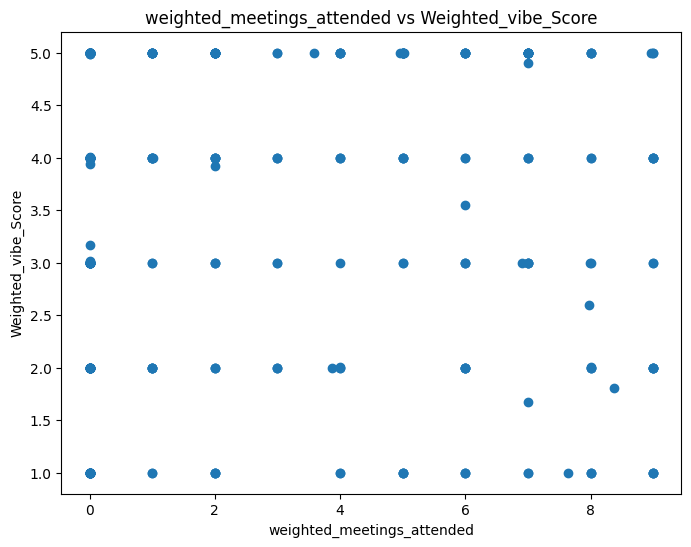

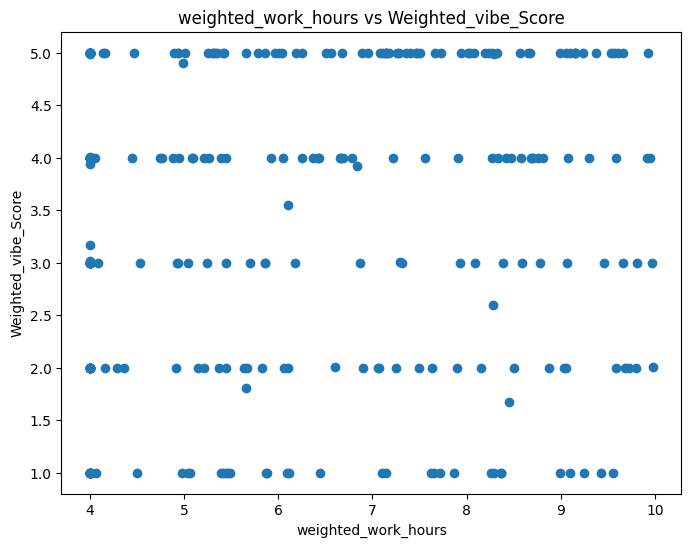

In [ ]:
for feature in independent_features:
  plt.figure(figsize=(8, 6))
  plt.scatter(df_merged[feature], df_merged['Weighted_vibe_Score'])
  plt.xlabel(feature)
  plt.ylabel('Weighted_vibe_Score')
  plt.title(f'{feature} vs Weighted_vibe_Score')
  plt.show()

In [ ]:
correlation_with_emotion = df_merged[independent_features + ['Weighted_vibe_Score']].corr()['Weighted_vibe_Score'][:-1]

print("Correlation between independent features and Weighted_vibe_Score:")
correlation_with_emotion

Correlation between independent features and Weighted_vibe_Score:


,Weighted_vibe_Score
weighted_teams_msgs_sent,0.002567
weighted_emails_sent,0.068833
weighted_meetings_attended,-0.057271
weighted_work_hours,0.031883


In [ ]:
df_merged.head()

,Employee_ID,weighted_teams_msgs_sent,weighted_emails_sent,weighted_meetings_attended,weighted_work_hours,Weighted_vibe_Score
0,EMP0002,38.000000,8.000000,9.000000,5.450000,1.0000
1,EMP0003,16.000000,28.000000,2.000000,4.090000,2.9996
2,EMP0004,0.000000,0.000000,0.000000,4.000000,4.0000
3,EMP0005,15.762871,26.861779,6.905148,5.044243,3.0000
4,EMP0006,49.000000,17.000000,6.000000,6.890000,5.0000


In [ ]:
X = df_merged[independent_features].values
y = df_merged['Weighted_vibe_Score'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
input_layer = Input(shape=(X_scaled.shape[1],))

encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded_feature = Dense(1, activation='linear', name='combined_feature')(encoded)

output_layer = Dense(1, activation='linear', name='vibe_score_prediction')(encoded_feature)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mse')

model.fit(X_scaled, y, epochs=500, batch_size=8, verbose=1, shuffle=True)

Epoch 1/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 12.2602
Epoch 2/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0420
Epoch 3/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8236
Epoch 4/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5756
Epoch 5/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5525
Epoch 6/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4969
Epoch 7/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6912
Epoch 8/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3122
Epoch 9/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4130
Epoch 10/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2618
Epoch 11/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3650
Epoch 12/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2628
Epoch 13/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1523
Epoch 14/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3940
Epoch 15/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3217
Epo

In [ ]:
encoder = Model(inputs=input_layer, outputs=encoded_feature)
df_merged['combined_feature_activity'] = encoder.predict(X_scaled)

df_merged[['Employee_ID', 'combined_feature_activity', 'Weighted_vibe_Score']]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


,Employee_ID,combined_feature_activity,Weighted_vibe_Score
0,EMP0002,-0.580306,1.0000
1,EMP0003,-1.439574,2.9996
2,EMP0004,-1.560032,4.0000
3,EMP0005,-1.697143,3.0000
4,EMP0006,-2.313892,5.0000
...,...,...,...
310,EMP0491,-2.394855,5.0000
311,EMP0493,-1.269945,2.0074
312,EMP0497,-1.560032,2.0000
313,EMP0498,-1.560032,5.0000


In [ ]:
print(df_merged[['combined_feature_activity', 'Weighted_vibe_Score']].corr())

                           combined_feature_activity  Weighted_vibe_Score
combined_feature_activity                   1.000000            -0.749464
Weighted_vibe_Score                        -0.749464             1.000000


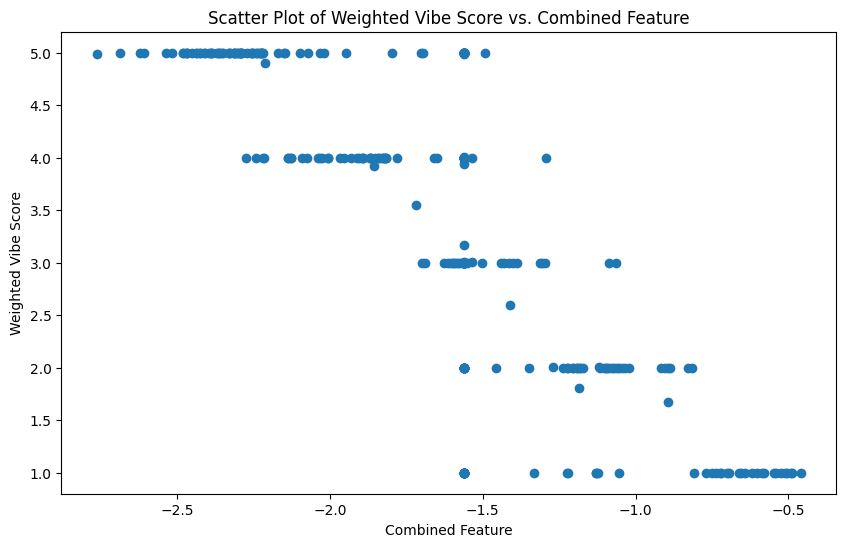

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['combined_feature_activity'], df_merged['Weighted_vibe_Score'])
plt.xlabel('Combined Feature')
plt.ylabel('Weighted Vibe Score')
plt.title('Scatter Plot of Weighted Vibe Score vs. Combined Feature')
plt.show()

In [ ]:
df_merged.head()

,Employee_ID,weighted_teams_msgs_sent,weighted_emails_sent,weighted_meetings_attended,weighted_work_hours,Weighted_vibe_Score,combined_feature_activity
0,EMP0002,38.000000,8.000000,9.000000,5.450000,1.0000,-0.580306
1,EMP0003,16.000000,28.000000,2.000000,4.090000,2.9996,-1.439574
2,EMP0004,0.000000,0.000000,0.000000,4.000000,4.0000,-1.560032
3,EMP0005,15.762871,26.861779,6.905148,5.044243,3.0000,-1.697143
4,EMP0006,49.000000,17.000000,6.000000,6.890000,5.0000,-2.313892


In [ ]:
quantile_20 = df_merged['combined_feature_activity'].quantile(0.2)
quantile_80 = df_merged['combined_feature_activity'].quantile(0.8)
range_80_20 = quantile_80 - quantile_20

In [ ]:
quantile_20

np.float64(-2.138150453567505)

In [ ]:
df_merged['should_chat_activity'] = np.where(
    df_merged['combined_feature_activity'] < quantile_20,
    ((df_merged['combined_feature_activity'] - quantile_20) / range_80_20) * 100,
    np.where(
        df_merged['combined_feature_activity'] > quantile_80,
        ((df_merged['combined_feature_activity'] - quantile_80) / range_80_20) * 100,
        0
    )
)

In [ ]:
df_merged.head()

,Employee_ID,weighted_teams_msgs_sent,weighted_emails_sent,weighted_meetings_attended,weighted_work_hours,Weighted_vibe_Score,combined_feature_activity,should_chat_activity
0,EMP0002,38.000000,8.000000,9.000000,5.450000,1.0000,-0.580306,83.390930
1,EMP0003,16.000000,28.000000,2.000000,4.090000,2.9996,-1.439574,0.000000
2,EMP0004,0.000000,0.000000,0.000000,4.000000,4.0000,-1.560032,0.000000
3,EMP0005,15.762871,26.861779,6.905148,5.044243,3.0000,-1.697143,0.000000
4,EMP0006,49.000000,17.000000,6.000000,6.890000,5.0000,-2.313892,-20.688471


In [ ]:
df_merged.to_csv('combined_feature_activity.csv', index = False)